In [1]:
import pandas as pd

In [2]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import ast
from datetime import datetime, timedelta
import seaborn as sns
sns.set()
sns.set_style("white")
#sns.set_palette("GnBu_d")
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', None)

In [3]:
data = pd.read_pickle("preparedData.pkl")
data_withNULL= pd.read_pickle("preparedData.pkl")
data

,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,userID,combinedSpaceStationID,timeConnected,idleTime,chargingTime,weekday,month,time,WhPerMile,kWhRequested,milesRequested,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture
0,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1,194.0,AG-3F30/1-1-179-810,21741.0,5980.0,15761.0,3,1,13:08:54,250.0,25.00,100.0,463.0,"Thu, 02 Jan 2020 13:09:39 GMT",True,"Thu, 02 Jan 2020 20:51:54 GMT"
1,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1,4275.0,AG-1F01/1-1-193-825,32491.0,8416.0,24075.0,3,1,13:36:50,280.0,70.00,250.0,595.0,"Thu, 02 Jan 2020 13:37:11 GMT",True,"Thu, 02 Jan 2020 23:31:50 GMT"
2,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1,344.0,AG-1F03/1-1-193-829,38567.0,29056.0,9511.0,3,1,13:56:35,400.0,8.00,20.0,60.0,"Thu, 02 Jan 2020 13:57:17 GMT",True,"Thu, 02 Jan 2020 14:56:35 GMT"
3,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1,1117.0,AG-1F04/1-1-193-820,9521.0,4794.0,4727.0,3,1,13:59:58,400.0,8.00,20.0,65.0,"Thu, 02 Jan 2020 14:00:03 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT"
4,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1,334.0,AG-1F06/1-1-193-819,29319.0,13870.0,15449.0,3,1,14:00:01,400.0,16.00,40.0,504.0,"Thu, 02 Jan 2020 14:00:13 GMT",True,"Thu, 02 Jan 2020 22:24:01 GMT"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56531,2019-07-01 19:13:11+00:00,2019-07-02 00:44:40+00:00,2019-07-01 21:13:56+00:00,6.048,1,2643.0,AG-3F23/1-1-179-797,19889.0,12644.0,7245.0,0,7,19:13:11,275.0,8.25,30.0,374.0,"Mon, 01 Jul 2019 19:13:10 GMT",True,"Tue, 02 Jul 2019 01:27:11 GMT"
56532,2019-07-01 19:43:46+00:00,2019-07-02 02:58:53+00:00,2019-07-02 02:43:53+00:00,41.047,1,394.0,AG-4F38/1-1-191-793,26107.0,900.0,25207.0,0,7,19:43:46,231.0,36.96,160.0,310.0,"Mon, 01 Jul 2019 19:43:58 GMT",True,"Tue, 02 Jul 2019 00:53:46 GMT"
56533,2019-07-01 20:34:30+00:00,2019-07-02 00:30:52+00:00,2019-07-01 21:27:44+00:00,5.390,1,2276.0,AG-3F15/1-1-179-813,14182.0,10988.0,3194.0,0,7,20:34:30,300.0,12.00,40.0,381.0,"Mon, 01 Jul 2019 20:34:29 GMT",True,"Tue, 02 Jul 2019 02:55:30 GMT"
56534,2019-07-01 21:49:12+00:00,2019-07-02 01:37:18+00:00,2019-07-01 23:14:33+00:00,8.399,1,1346.0,AG-3F18/1-1-179-798,13686.0,8565.0,5121.0,0,7,21:49:12,400.0,32.00,80.0,36.0,"Mon, 01 Jul 2019 21:49:37 GMT",True,"Mon, 01 Jul 2019 22:25:12 GMT"


### KPI1
Station Downtime Between Sessions
total accumulated disconnect time
Description: Measures the duration of time that a charging station remains "free" or inactive before the next connection occurs, indicating how quickly the station is utilized between sessions

In [4]:
# Sortieren Sie das DataFrame nach 'combinedSpaceStationID' und 'disconnectTime'
data = data.sort_values(by=['combinedSpaceStationID', 'disconnectTime'])

# Berechnen Sie die Downzeiten und speichern Sie sie in einer neuen Spalte 'downTime'
data['downTime'] = data.groupby('combinedSpaceStationID')['connectionTime'].shift(-1) - data['disconnectTime']

# Füllen Sie NaN-Werte in der letzten Zeile der Gruppen mit 0 (da es keine nächste Session gibt)
data['downTime'] = data['downTime'].fillna(pd.Timedelta(seconds=0))

# Summieren Sie die Downzeiten und berechnen Sie den Durchschnitt für jede 'combinedSpaceStationID'
result = data.groupby('combinedSpaceStationID')['downTime'].agg(['sum', 'mean']).reset_index()
result.columns = ['combinedSpaceStationID', 'sumDownTime', 'avgDownTime']

result

,combinedSpaceStationID,sumDownTime,avgDownTime
0,AG-1F01/1-1-193-825,859 days 02:42:33,1 days 02:40:25.036222509
1,AG-1F02/1-1-193-827,816 days 06:55:40,0 days 21:17:40.152173913
2,AG-1F03/1-1-193-829,864 days 01:02:15,1 days 03:27:58.589403973
3,AG-1F04/1-1-193-820,820 days 15:00:03,0 days 19:54:50.599595551
4,AG-1F05/1-1-193-816,859 days 01:11:27,1 days 03:44:54.868102288
...,...,...,...
101,CA-509/2-39-129-563,600 days 23:51:03,7 days 10:04:20.037037037
102,CA-510/2-39-130-564,627 days 00:41:01,4 days 17:08:52.789473684
103,CA-511/2-39-131-565,554 days 05:03:38,5 days 14:21:14.929292929
104,CA-512/2-39-138-566,1138 days 04:18:11,6 days 20:33:21.753012048


### KPI 2.0: Total Idle Time
Sums up the idle time per combinedSpaceStationID (in seconds)
Formula: Sum of idle time per combinedSpaceStationID

### KPI 2.1: Mean Idle Time
Calculates the mean idle time per combinedSpaceStationID (in seconds)
Formula: Mean idle time per combinedSpaceStationID

In [5]:
result_idle_sum = data.groupby('combinedSpaceStationID')['idleTime'].sum()

result_idle_mean = data.groupby('combinedSpaceStationID')['idleTime'].mean()

print(result_idle_sum)
print(result_idle_mean)

combinedSpaceStationID
AG-1F01/1-1-193-825     7370035.0
AG-1F02/1-1-193-827    11088828.0
AG-1F03/1-1-193-829     7055863.0
AG-1F04/1-1-193-820     9944936.0
AG-1F05/1-1-193-816     6982929.0
                          ...    
CA-509/2-39-129-563      845806.0
CA-510/2-39-130-564     1112803.0
CA-511/2-39-131-565     1060237.0
CA-512/2-39-138-566     1656945.0
CA-513/2-39-139-567      894336.0
Name: idleTime, Length: 106, dtype: float64
combinedSpaceStationID
AG-1F01/1-1-193-825     9534.327296
AG-1F02/1-1-193-827    12053.073913
AG-1F03/1-1-193-829     9345.513907
AG-1F04/1-1-193-820    10055.547017
AG-1F05/1-1-193-816     9398.289367
                           ...     
CA-509/2-39-129-563    10442.049383
CA-510/2-39-130-564     8366.939850
CA-511/2-39-131-565    10709.464646
CA-512/2-39-138-566     9981.596386
CA-513/2-39-139-567     8599.384615
Name: idleTime, Length: 106, dtype: float64


### KPI 3: Station Utilization
Quantifies the relation between the total time of usage of a station and the total elapsed time since the first session record
Formula: (Total Sum of timeConnected) / total hours

In [6]:
first_record = data['connectionTime'].min()
last_record = data['connectionTime'].max()
#today_date = pd.Timestamp.now(tz = 'Europe/Berlin')
#range = today_date - first_record
range = last_record - first_record

station_utilization = data.groupby('combinedSpaceStationID')['timeConnected'].sum()

station_utilization = pd.to_timedelta(station_utilization, unit="s") / range

station_utilization

#1 Strings userID
#2 Zeiten als Minuten oder anderes Format
#Ratio Sinnvoller?!?!?
#may change over time????

combinedSpaceStationID
AG-1F01/1-1-193-825    0.171352
AG-1F02/1-1-193-827    0.205730
AG-1F03/1-1-193-829    0.167178
AG-1F04/1-1-193-820    0.202516
AG-1F05/1-1-193-816    0.171560
                         ...   
CA-509/2-39-129-563    0.017247
CA-510/2-39-130-564    0.026828
CA-511/2-39-131-565    0.019941
CA-512/2-39-138-566    0.036668
CA-513/2-39-139-567    0.019579
Name: timeConnected, Length: 106, dtype: float64

### KPI4
Most Frequently Utilized Stations
Description: Identifies the stations that are used most frequently based on customer session data

In [7]:
#Group data by 'station_id' and count the number of occurrences
station_usage_counts = data['combinedSpaceStationID'].value_counts()

#Sort the stations by usage count in descending order
sorted_stations = station_usage_counts.sort_values(ascending=False)

#Display the most frequently used stations
print("Most Frequently Utilized Stations:")
print(sorted_stations.head(10))  # Adjust the number to display more or fewer stations

Most Frequently Utilized Stations:
combinedSpaceStationID
CA-303/2-39-139-28     1696
CA-305/2-39-131-30     1330
AG-1F08/1-1-178-823    1217
AG-1F10/1-1-178-828    1077
CA-307/2-39-129-17     1061
CA-315/2-39-89-25      1024
AG-1F06/1-1-193-819    1019
AG-1F04/1-1-193-820     989
CA-311/2-39-125-21      989
CA-309/2-39-127-19      970
Name: count, dtype: int64


### KPI 5: Site utilization
Counts the number of session for each site
Formula: Count of entries for each siteID

In [8]:
site_usage_counts = data['siteID'].value_counts()

sorted_sites = site_usage_counts.sort_values(ascending=False)

print("Most Frequently Utilized Sites:")
print(sorted_sites)

Most Frequently Utilized Sites:
siteID
1    28384
2    28152
Name: count, dtype: int64


### KPI 6.0: Total kWh Charged per station
Sum up energy consumption for each station
Formula: Sum of energy consumption for each station

### KPI 6.1: Total kWh Charged (in the last 24 hours) per station
Sum up energy consumption for each station in last 24 hours
Formula: Sum of energy consumption for each station in last 24 hours

In [9]:
total_energy_consumption = data.groupby('combinedSpaceStationID')['kWhDelivered'].sum()

timestamp_now = pd.Timestamp.now(tz = 'Europe/Berlin')
total_energy_consumption_recent = data[timestamp_now - data['connectionTime'] <= timedelta(hours=24)].groupby('combinedSpaceStationID')['kWhDelivered'].sum()

print(total_energy_consumption)
print(total_energy_consumption_recent)

combinedSpaceStationID
AG-1F01/1-1-193-825    12037.228215
AG-1F02/1-1-193-827     9121.445106
AG-1F03/1-1-193-829    10480.305870
AG-1F04/1-1-193-820    10904.378000
AG-1F05/1-1-193-816    10945.803964
                           ...     
CA-509/2-39-129-563      664.605000
CA-510/2-39-130-564     1041.907976
CA-511/2-39-131-565      852.859005
CA-512/2-39-138-566     1336.292663
CA-513/2-39-139-567      963.810000
Name: kWhDelivered, Length: 106, dtype: float64
Series([], Name: kWhDelivered, dtype: float64)


### KPI7
Average Energy Delivered per Session
Formula: (Total kWh Charged) / (Total Number of Sessions)
Description: Calculates the average energy consumption per charging session, aiding in assessing energy delivery efficiency

In [10]:
overall_average_energy_delivered = data['kWhDelivered'].mean()
overall_average_energy_delivered

11.381496936069817

### KPI8
Average Session Duration
Formula: (Total Session Duration) / (Total Number of Sessions)
Description: Measures the average duration of charging sessions, assisting in evaluating station turnover rates

In [11]:
avg_session_duration = data['timeConnected'].mean()

# Anzeigen oder Verwenden der durchschnittlichen Dauer einer Session
print("Durchschnittliche Dauer einer Session:", avg_session_duration)

Durchschnittliche Dauer einer Session: 23524.884639875476


### KPI9
Peak Demand Hours
Description: Identifies the hours with the highest energy demand, facilitating load management and pricing optimization

### KPI10
Registered and Unregistered Customer Ratio
Formula: (Number of Registered Customers) / (Number of Unregistered Customers)
Description: Compares the ratio of registered (loyal) customers to unregistered (casual) customers, providing insights into registration program

### KPI 11: Repeating Customer Rate
Expresses the percentage of customers who return for multiple charging sessions, indicating customer loyalty
Formula: Number of repeating customers / total number of customers

In [12]:
number_of_session = len(data)
number_of_sessions_with_uf = len(data[data['userID'].notna()])

number_customer_total = data['userID'].dropna().astype(str).nunique()

returning_customer = data.groupby('userID').size()
returning_customer = returning_customer[returning_customer > 1].count()


print(
    f"With {number_of_sessions_with_uf/number_of_session:.2f} percent of the charging sessions we can identify the user based on the userID. "
    f"From the {number_customer_total} customers there are {returning_customer} returning users. "
    f"The ratio between returning customers and the total number of customers is {returning_customer/number_customer_total:.2f} percent."
)

With 0.73 percent of the charging sessions we can identify the user based on the userID. From the 872 customers there are 743 returning users. The ratio between returning customers and the total number of customers is 0.85 percent.


### Charging Duration

In order to complete hourly KPI analysis, we need to add further information to our charging_sessions_modified dataset such as the respective hour for the connectionTime and the conversion of the idleTime (describing how long a car is still connected to the device even though it is already fully charged) in minutes.

In [13]:
data.dropna(inplace=True)
data["hour_connecttime"] = data["connectionTime"].dt.hour
data['date_connecttime'] = data['connectionTime'].dt.date
data['weekday_connecttime'] = data['connectionTime'].dt.weekday
data['month_connecttime'] = data['connectionTime'].dt.month
data["chargingTime_minutes"] = data["chargingTime"]/60

Text(0.5, 1.0, 'Median duration of a charging session per hour (KPI)')

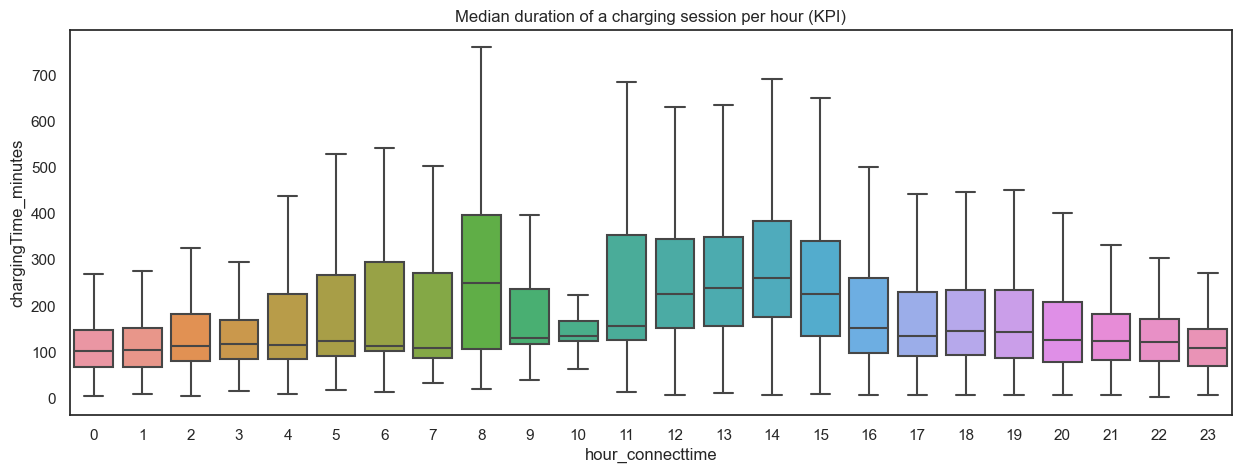

In [14]:
f, axes = plt.subplots(1, 1, figsize=(15, 5))

sns.boxplot(x = "hour_connecttime", y = "chargingTime_minutes", data= data, ax=axes, showfliers=False)
axes.set_title("Median duration of a charging session per hour (KPI)")

### Session duration

Durchschnittliche Dauer einer Session: 23524.884639875476


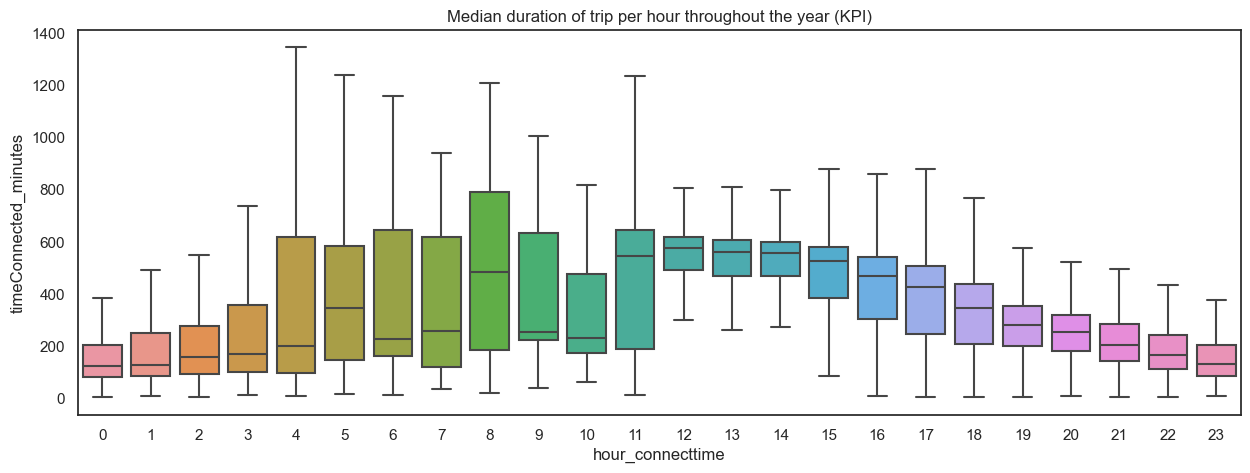

In [15]:
#Add the session duration 
#KPI8
#Average Session Duration
#Formula: (Total Session Duration) / (Total Number of Sessions)
#Description: Measures the average duration of charging sessions, assisting in evaluating station turnover rates
#avg_session_duration = charging_sessions_modified['timeConnected'].mean()
duration_df=data.copy()
import pandas as pd


# Assuming your DataFrame is named duration_df
# Extract date-related information from the connectionTime column
# duration_df['date_connecttime'] = duration_df['connectionTime'].dt.date
# duration_df['weekday_connecttime'] = duration_df['connectionTime'].dt.weekday
# duration_df['hour_connecttime'] = duration_df['connectionTime'].dt.hour
# duration_df['month_connecttime'] = duration_df['connectionTime'].dt.month
data

f, axes = plt.subplots(1, 1, figsize=(15, 5))
data['timeConnected_minutes']=(data['timeConnected']/60)

sns.boxplot(x = "hour_connecttime", y = "timeConnected_minutes", data= data, ax=axes, showfliers=False)
axes.set_title("Median duration of trip per hour throughout the year (KPI)")
# Anzeigen oder Verwenden der durchschnittlichen Dauer einer Session
print("Durchschnittliche Dauer einer Session:", avg_session_duration)

### Idle time

In [16]:
data["idleTime_minutes"] = data["idleTime"]/60

Text(0.5, 1.0, 'Median idleTime of a charging session per hour (KPI)')

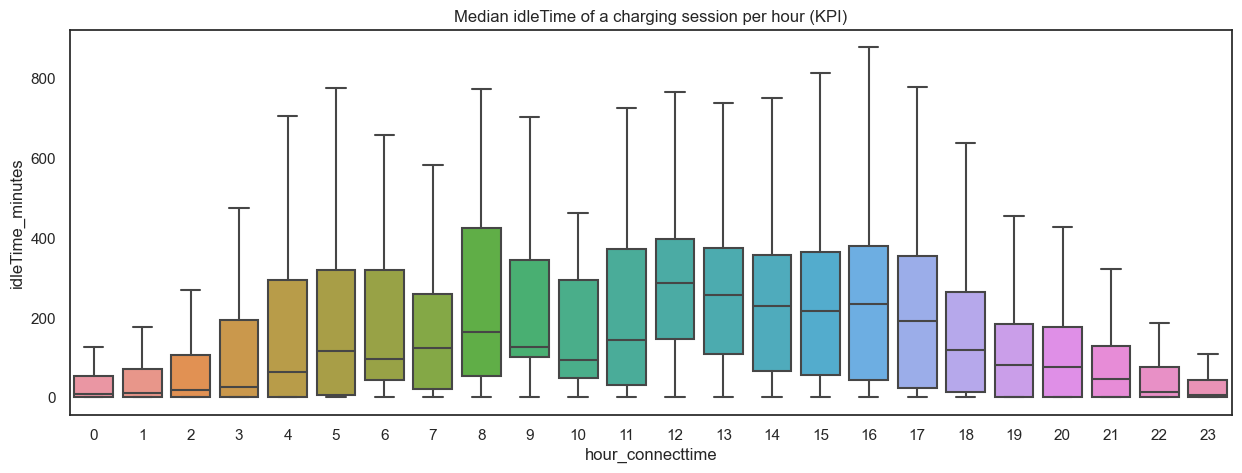

In [17]:
f, axes = plt.subplots(1, 1, figsize=(15, 5))

sns.boxplot(x = "hour_connecttime", y = "idleTime_minutes", data= data, ax=axes, showfliers=False)
axes.set_title("Median idleTime of a charging session per hour (KPI)")

### Genral Demand
Number of connections per hour

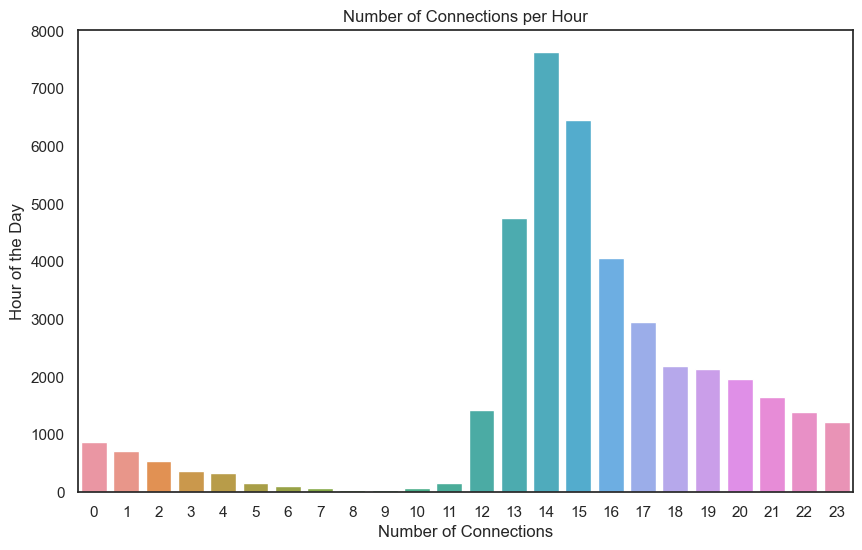

In [18]:
# Group the data by the 'hour' column and count the number of connections
connections_per_hour = data.groupby('hour_connecttime').size().reset_index(name='Number of Connections')

# Create a boxplot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='hour_connecttime', y='Number of Connections', data=connections_per_hour)
plt.title('Number of Connections per Hour')
plt.xlabel('Number of Connections')
plt.ylabel('Hour of the Day')
plt.show()

## Proportion of the fleet 

In [26]:
#calculate the number of stations
number_stations = len(data["combinedSpaceStationID"].unique())
number_stations

105

In [32]:
#create a dataframe with the number of different stations IDs occupied every hour
charging_sessions_modified_tempered_hour123 = data.groupby([data["connectionTime"].dt.date,"hour_connecttime"])["combinedSpaceStationID"].nunique()
charging_sessions_modified_tempered_hour123= pd.DataFrame(charging_sessions_modified_tempered_hour123)

In [33]:
charging_sessions_modified_tempered_hour123

combinedSpaceStationID
connectionTime hour_connecttime                        
2018-04-30     15                                     1
2018-05-07     14                                     1
2018-05-11     15                                     1
2018-05-14     13                                     1
2018-05-15     0                                      1
...                                                 ...
2021-09-13     20                                     2
               21                                     3
               23                                     1
2021-09-14     1                                      1
               5                                      1

[10501 rows x 1 columns]

In this dataframe we see the number of different stations occupied every hour. In the next step we divide it with the number of stages to get the proportion in percent.

In [34]:
#insert a new column with the calculated proportion of the fleet borrowed every hour
charging_sessions_modified_tempered_hour123["percentage"]=(charging_sessions_modified_tempered_hour123["combinedSpaceStationID"]/105)*100

In [35]:
charging_sessions_modified_tempered_hour123

combinedSpaceStationID  percentage
connectionTime hour_connecttime                                    
2018-04-30     15                                     1    0.952381
2018-05-07     14                                     1    0.952381
2018-05-11     15                                     1    0.952381
2018-05-14     13                                     1    0.952381
2018-05-15     0                                      1    0.952381
...                                                 ...         ...
2021-09-13     20                                     2    1.904762
               21                                     3    2.857143
               23                                     1    0.952381
2021-09-14     1                                      1    0.952381
               5                                      1    0.952381

[10501 rows x 2 columns]

As we can see a third column with percent values

Now we can plot it in a boxplot to the proportion of the stations occupied per day

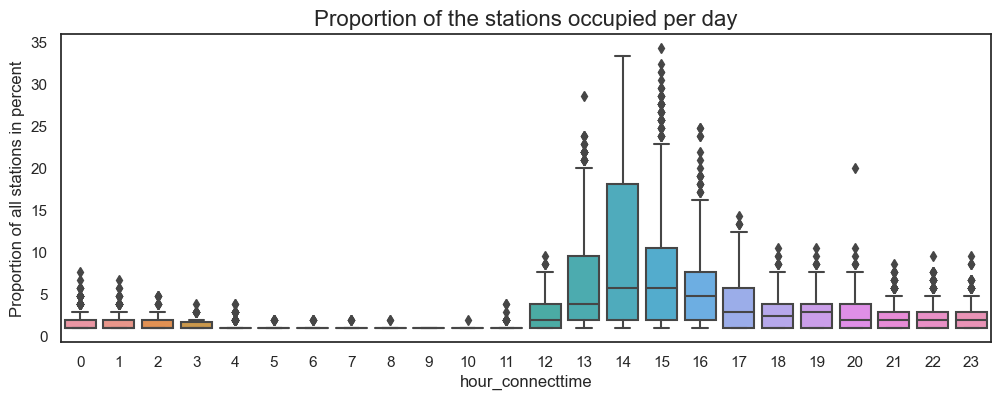

In [36]:
#plot the calculated proportion of the fleet borrowed per day
fig,ax = plt.subplots(figsize=(12,4)) 
sns.boxplot(x=charging_sessions_modified_tempered_hour123.index.get_level_values(1), y=charging_sessions_modified_tempered_hour123["percentage"],ax=ax)
ax.set_title("Proportion of the stations occupied per day",fontsize=16)
plt.ylabel('Proportion of all stations in percent')
plt.savefig("dayproportion.jpeg")
plt.show()

It also can be interesting to calculate the proportion of the stations occupied per week and the whole year. Because of this we plot two another visualizations for week and year in the same way.

In [37]:
#create a dataframe with the number of different stations IDs borrowed in a week
charging_sessions_modified_tempered_week1= data.groupby([data["connectionTime"].dt.date,"weekday"])["combinedSpaceStationID"].nunique()
charging_sessions_modified_tempered_week1= pd.DataFrame(charging_sessions_modified_tempered_week1)

In [38]:
#insert a new column with the calculated proportion of the fleet borrowed in one week
charging_sessions_modified_tempered_week1["percentage"]=(charging_sessions_modified_tempered_week1["combinedSpaceStationID"]/105)*100

In [39]:
charging_sessions_modified_tempered_week1

,,combinedSpaceStationID,percentage
connectionTime,weekday,,
2018-04-30,0,1,0.952381
2018-05-07,0,1,0.952381
2018-05-11,4,1,0.952381
2018-05-14,0,1,0.952381
2018-05-15,1,1,0.952381
...,...,...,...
2021-09-10,4,36,34.285714
2021-09-11,5,8,7.619048
2021-09-12,6,9,8.571429


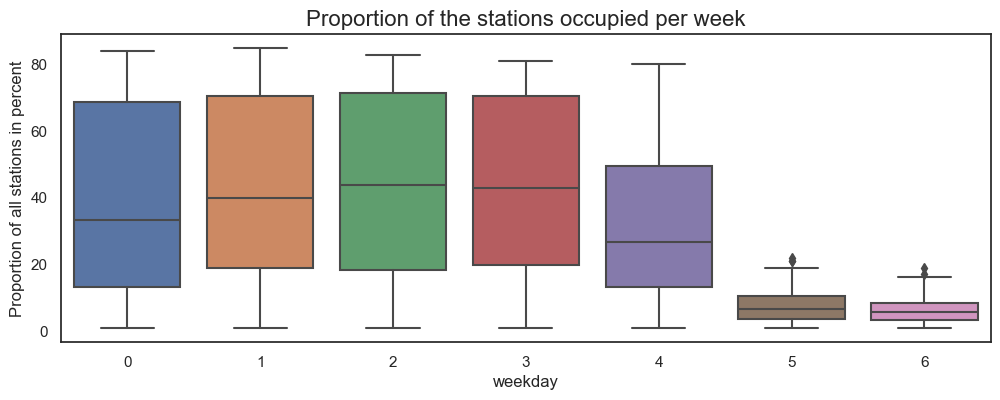

In [40]:
#plot the calculated proportion of the fleet per week
fig,ax = plt.subplots(figsize=(12,4)) 
sns.boxplot(x=charging_sessions_modified_tempered_week1.index.get_level_values(1), y=charging_sessions_modified_tempered_week1["percentage"],ax=ax)
ax.set_title("Proportion of the stations occupied per week",fontsize=16)
plt.ylabel('Proportion of all stations in percent')
plt.xlabel('weekday')
plt.savefig("weekproportion.jpeg")
plt.show()

In [41]:
#create a dataframe with the number of different stations IDs borrowed in a week
charging_sessions_modified_tempered_year1= data.groupby([data["connectionTime"].dt.date,"month"])["combinedSpaceStationID"].nunique()
charging_sessions_modified_tempered_year1= pd.DataFrame(charging_sessions_modified_tempered_year1)

In [42]:
#insert a new column with the calculated proportion of the fleet borrowed in one week
charging_sessions_modified_tempered_year1["percentage"]=(charging_sessions_modified_tempered_year1["combinedSpaceStationID"]/105)*100

In [43]:
charging_sessions_modified_tempered_year1

,,combinedSpaceStationID,percentage
connectionTime,month,,
2018-04-30,4,1,0.952381
2018-05-07,5,1,0.952381
2018-05-11,5,1,0.952381
2018-05-14,5,1,0.952381
2018-05-15,5,1,0.952381
...,...,...,...
2021-09-10,9,36,34.285714
2021-09-11,9,8,7.619048
2021-09-12,9,9,8.571429


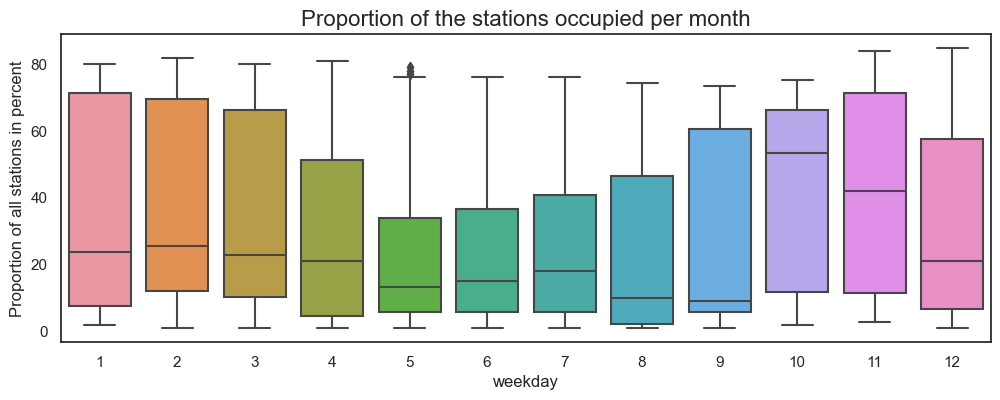

In [44]:
#plot the calculated proportion of the fleet per week
fig,ax = plt.subplots(figsize=(12,4)) 
sns.boxplot(x=charging_sessions_modified_tempered_year1.index.get_level_values(1), y=charging_sessions_modified_tempered_year1["percentage"],ax=ax)
ax.set_title("Proportion of the stations occupied per month",fontsize=16)
plt.ylabel('Proportion of all stations in percent')
plt.xlabel('weekday')
plt.savefig("weekproportion.jpeg")
plt.show()

**KPI 6**: Total kWh Charged\
Utilization can also be seen by reviewing the total number of KWh that have been charged at certain times. For visualization we use a boxplot.

In [45]:
data

,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,userID,combinedSpaceStationID,timeConnected,idleTime,chargingTime,...,paymentRequired,requestedDeparture,downTime,hour_connecttime,date_connecttime,weekday_connecttime,month_connecttime,chargingTime_minutes,timeConnected_minutes,idleTime_minutes
44985,2018-10-09 22:26:40+00:00,2018-10-10 02:48:12+00:00,2018-10-10 02:28:29+00:00,12.034,1,383.0,AG-1F01/1-1-193-825,15692.0,1183.0,14509.0,...,True,"Wed, 10 Oct 2018 02:18:40 GMT",0 days 10:26:50,22,2018-10-09,1,10,241.816667,261.533333,19.716667
45145,2018-10-12 17:07:47+00:00,2018-10-12 22:58:22+00:00,2018-10-12 21:46:28+00:00,14.289,1,335.0,AG-1F01/1-1-193-825,21035.0,4314.0,16721.0,...,True,"Fri, 12 Oct 2018 19:32:47 GMT",2 days 14:48:06,17,2018-10-12,4,10,278.683333,350.583333,71.900000
45171,2018-10-15 13:46:28+00:00,2018-10-16 00:43:30+00:00,2018-10-15 16:03:25+00:00,6.457,1,365.0,AG-1F01/1-1-193-825,39422.0,31205.0,8217.0,...,True,"Mon, 15 Oct 2018 14:46:28 GMT",0 days 13:30:20,13,2018-10-15,0,10,136.950000,657.033333,520.083333
45246,2018-10-16 14:13:50+00:00,2018-10-16 22:03:42+00:00,2018-10-16 17:11:45+00:00,7.416,1,374.0,AG-1F01/1-1-193-825,28192.0,17517.0,10675.0,...,True,"Tue, 16 Oct 2018 21:02:50 GMT",0 days 00:25:52,14,2018-10-16,1,10,177.916667,469.866667,291.950000
45290,2018-10-16 22:29:34+00:00,2018-10-17 03:30:34+00:00,2018-10-17 01:33:31+00:00,9.909,1,467.0,AG-1F01/1-1-193-825,18060.0,7023.0,11037.0,...,True,"Wed, 17 Oct 2018 02:31:34 GMT",0 days 10:00:18,22,2018-10-16,1,10,183.950000,301.000000,117.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19817,2019-04-09 18:30:12+00:00,2019-04-09 23:04:32+00:00,2019-04-09 21:18:28+00:00,8.766,2,777.0,CA-513/2-39-139-567,16460.0,6364.0,10096.0,...,True,"Tue, 09 Apr 2019 23:44:12 GMT",7 days 20:55:03,18,2019-04-09,1,4,168.266667,274.333333,106.066667
20087,2019-04-17 19:59:35+00:00,2019-04-17 20:37:45+00:00,2019-04-17 20:37:36+00:00,2.089,2,1093.0,CA-513/2-39-139-567,2290.0,9.0,2281.0,...,True,"Thu, 18 Apr 2019 00:31:35 GMT",0 days 00:56:13,19,2019-04-17,2,4,38.016667,38.166667,0.150000
20090,2019-04-17 21:33:58+00:00,2019-04-17 23:56:33+00:00,2019-04-17 23:47:29+00:00,14.393,2,668.0,CA-513/2-39-139-567,8555.0,544.0,8011.0,...,True,"Thu, 18 Apr 2019 00:52:58 GMT",6 days 16:04:03,21,2019-04-17,2,4,133.516667,142.583333,9.066667
20901,2019-05-13 19:43:12+00:00,2019-05-13 21:54:33+00:00,2019-05-13 20:46:37+00:00,2.308,2,560.0,CA-513/2-39-139-567,7881.0,4076.0,3805.0,...,True,"Mon, 13 May 2019 21:56:12 GMT",30 days 18:59:09,19,2019-05-13,0,5,63.416667,131.350000,67.933333


Text(0.5, 1.0, 'kWh charged per hour')

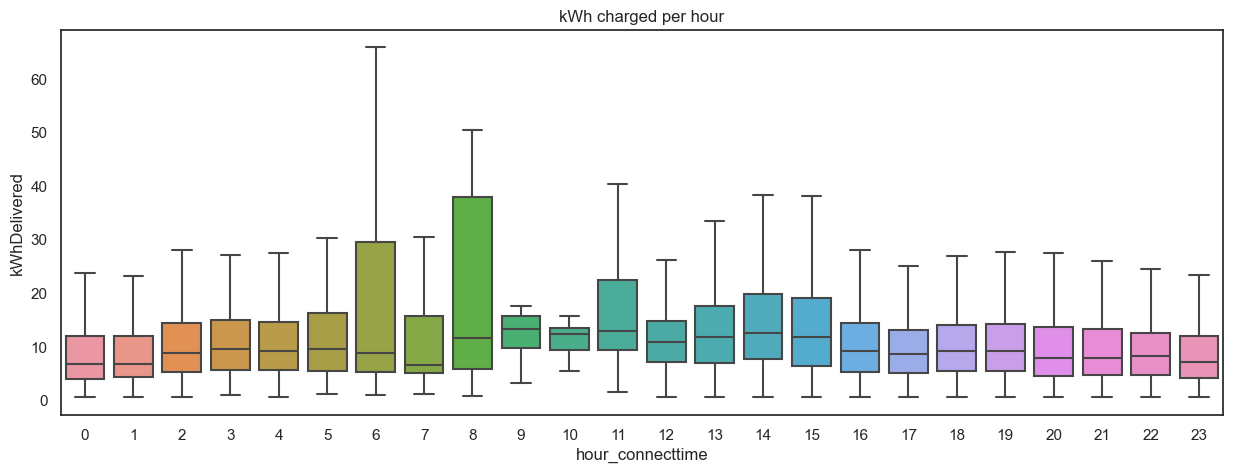

In [47]:
f, axes = plt.subplots(1, 1, figsize=(15, 5))

sns.boxplot(x = "hour_connecttime", y = "kWhDelivered", data= data, ax=axes, showfliers=False)
axes.set_title("kWh charged per hour")

In [50]:
#Description: Identifies the stations that are used most frequently based on customer session data
#Group data by 'station_id' and count the number of occurrences of unique values
station_usage_counts = data['combinedSpaceStationID'].value_counts()

#Sort the stations by usage count in descending order
sorted_stations = station_usage_counts.sort_values(ascending=False)

#Display the most frequently used stations
print("Most Frequently Utilized Stations:")
print(sorted_stations.head(10))  # Adjust the number to display more or fewer stations

Most Frequently Utilized Stations:
combinedSpaceStationID
AG-1F08/1-1-178-823    1177
CA-303/2-39-139-28     1040
AG-1F10/1-1-178-828    1037
AG-1F06/1-1-193-819     980
AG-1F04/1-1-193-820     943
AG-1F13/1-1-194-821     926
AG-1F02/1-1-193-827     892
CA-305/2-39-131-30      794
AG-1F12/1-1-194-822     752
AG-1F11/1-1-194-826     750
Name: count, dtype: int64


### Downtime

In [83]:
import pandas as pd

# Assuming you have a DataFrame 'charging_sessions_modified' with the necessary columns

# Sort the DataFrame by 'combinedSpaceStationID' and 'disconnectTime'
charging_sessions_modified_DOWNTIME_failed = data.sort_values(by=['combinedSpaceStationID', 'disconnectTime'])

# Calculate downtime in minutes and store it in a new column 'downTime_minutes'
charging_sessions_modified_DOWNTIME_failed['downTime_minutes'] = (charging_sessions_modified_DOWNTIME_failed.groupby('combinedSpaceStationID')['connectionTime'].shift(-1) - data['disconnectTime']).dt.total_seconds() / 60

# Fill NaN values in the last row of each group with 0 (since there is no next session)
charging_sessions_modified_DOWNTIME_failed['downTime_minutes'] = charging_sessions_modified_DOWNTIME_failed['downTime_minutes'].fillna(0)

# Capture the beginning of the downtime as 'beginningOfDowntime' (disconnectTime)
charging_sessions_modified_DOWNTIME_failed['beginningOfDowntime'] = charging_sessions_modified_DOWNTIME_failed['disconnectTime']

# Extract the hour from 'beginningOfDowntime' and store it in a new column 'hour_beginningOfDowntime'
charging_sessions_modified_DOWNTIME_failed['hour_beginningOfDowntime'] = charging_sessions_modified_DOWNTIME_failed['beginningOfDowntime'].dt.hour

# Sum and calculate the mean downtime in minutes, and include 'beginningOfDowntime' and 'hour_beginningOfDowntime' for each 'combinedSpaceStationID'
result = charging_sessions_modified_DOWNTIME_failed.groupby('combinedSpaceStationID').agg(
    sumDownTime_minutes=pd.NamedAgg(column='downTime_minutes', aggfunc='sum'),
    avgDownTime_minutes=pd.NamedAgg(column='downTime_minutes', aggfunc='mean'),
    beginningOfDowntime=pd.NamedAgg(column='beginningOfDowntime', aggfunc='first'),
    hour_beginningOfDowntime=pd.NamedAgg(column='hour_beginningOfDowntime', aggfunc='first')
).reset_index()

result


,combinedSpaceStationID,sumDownTime_minutes,avgDownTime_minutes,beginningOfDowntime,hour_beginningOfDowntime
0,AG-1F01/1-1-193-825,1.249331e+06,1699.769592,2018-10-10 02:48:12+00:00,2
1,AG-1F02/1-1-193-827,1.183591e+06,1326.896058,2018-10-09 18:54:43+00:00,18
2,AG-1F03/1-1-193-829,1.250284e+06,1724.529494,2018-10-11 01:02:39+00:00,1
3,AG-1F04/1-1-193-820,1.194193e+06,1266.376034,2018-10-09 07:30:15+00:00,7
4,AG-1F05/1-1-193-816,1.254723e+06,1802.762979,2018-10-09 00:05:33+00:00,0
...,...,...,...,...,...
100,CA-509/2-39-129-563,8.668943e+05,108361.783333,2018-05-22 01:22:53+00:00,1
101,CA-510/2-39-130-564,6.956467e+05,36612.981579,2018-10-20 04:38:04+00:00,4
102,CA-511/2-39-131-565,5.544885e+05,36965.898889,2018-09-29 00:01:09+00:00,0
103,CA-512/2-39-138-566,1.460876e+06,69565.532540,2018-10-11 02:07:51+00:00,2


In [84]:
# Assuming you have the DataFrame 'result' with the 'hour_beginningOfDowntime' column

# Count the occurrences of each hour as the beginning of downtime
hour_counts = result['hour_beginningOfDowntime'].value_counts().reset_index()
hour_counts.columns = ['Hour', 'Count']

# Sort the results by the hour
hour_counts = hour_counts.sort_values(by='Hour')

print(hour_counts)


    Hour  Count
0      0     39
3      1      9
2      2      9
12     3      2
7      4      3
16     5      1
15     7      1
9     13      2
14    15      1
10    16      2
8     17      2
5     18      5
13    19      1
11    20      2
6     21      4
4     22      8
1     23     14


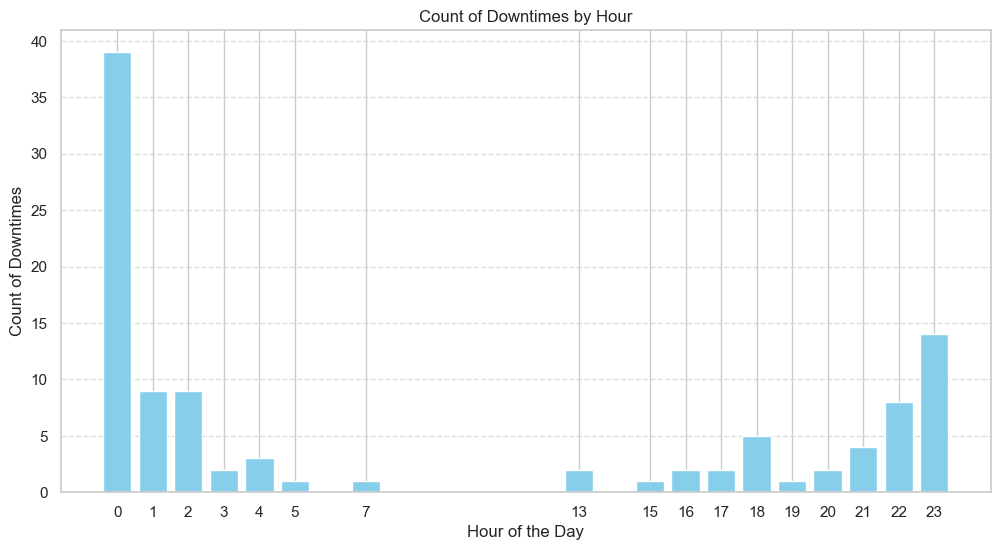

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrame 'hour_counts' with 'Hour' and 'Count' columns

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(hour_counts['Hour'], hour_counts['Count'], color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Downtimes')
plt.title('Count of Downtimes by Hour')
plt.xticks(hour_counts['Hour'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


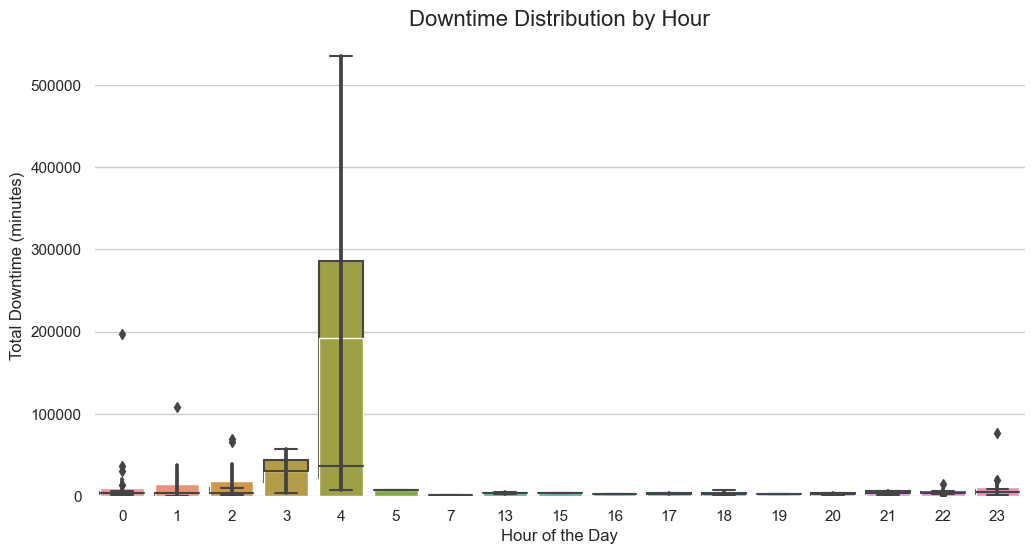

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the DataFrame 'result' with 'hour_beginningOfDowntime' and 'sumDownTime_minutes' columns

# Create a boxplot using Seaborn
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Customize the style
sns.boxplot(x='hour_beginningOfDowntime', y='avgDownTime_minutes', data=result)
sns.barplot(x='hour_beginningOfDowntime', y='avgDownTime_minutes', data=result)


# Customize labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Total Downtime (minutes)')
plt.title('Downtime Distribution by Hour', fontsize=16)

# Adjust the plot aesthetics
sns.despine(left=True, bottom=True)  # Remove spines from left and bottom

plt.show()


<Axes: xlabel='hour_beginningOfDowntime', ylabel='sumDownTime_minutes'>

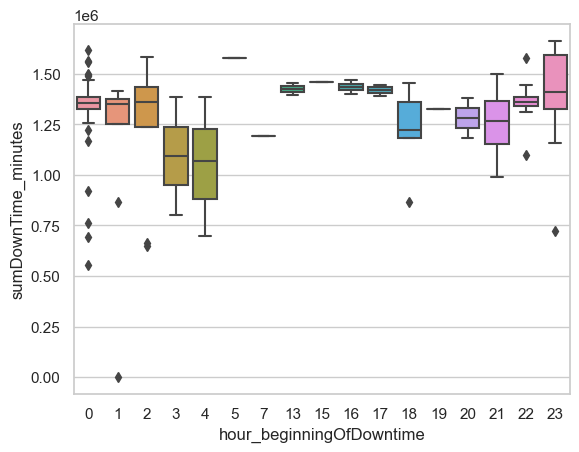

In [88]:
sns.boxplot(x='hour_beginningOfDowntime', y='sumDownTime_minutes', data=result)

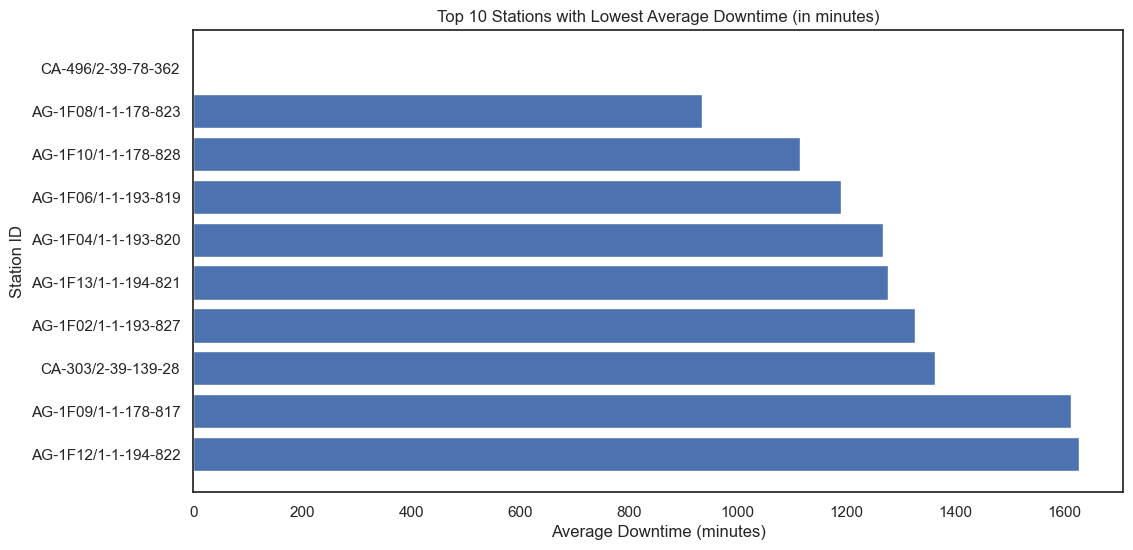

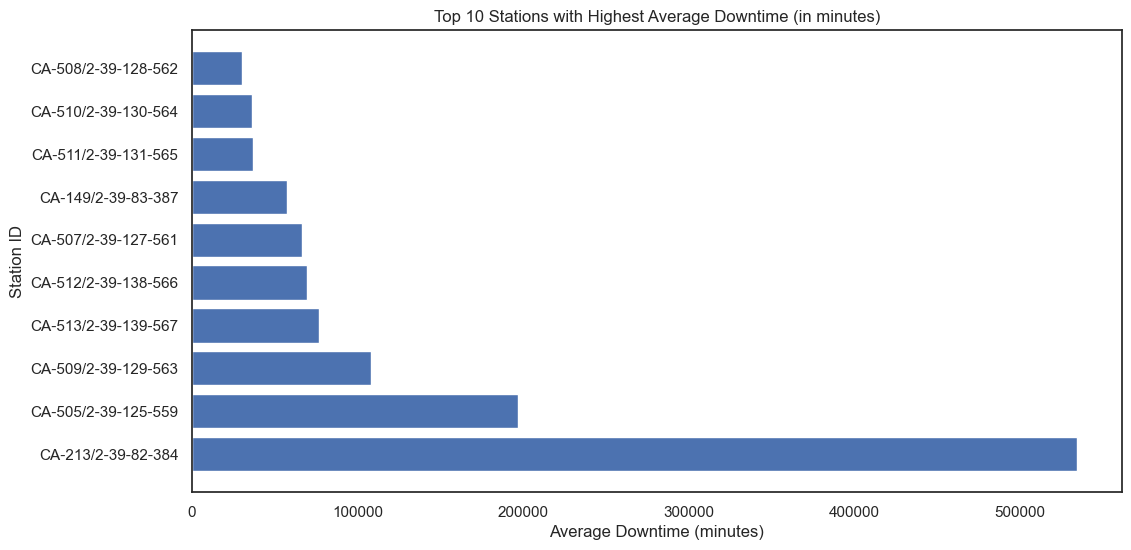

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrame 'result' as described
# Sort the DataFrame by 'avgDownTime_seconds' in ascending order (lowest first)
result_sorted = result.sort_values(by='avgDownTime_seconds')

# Convert average downtime from seconds to hours
result_sorted['avgDownTime_minutes'] = result_sorted['avgDownTime_seconds'] / 60

# Select the top 10 stations with the lowest average downtime in hours
top_10_lowest_avg_downtime = result_sorted.head(10)

# Select the top 10 stations with the highest average downtime in hours
top_10_highest_avg_downtime = result_sorted.tail(10)

# Create a plot for the top 10 lowest average downtime stations in hours
plt.figure(figsize=(12, 6))
plt.barh(top_10_lowest_avg_downtime['combinedSpaceStationID'], top_10_lowest_avg_downtime['avgDownTime_minutes'])
plt.title('Top 10 Stations with Lowest Average Downtime (in minutes)')
plt.xlabel('Average Downtime (minutes)')
plt.ylabel('Station ID')
plt.gca().invert_yaxis()  # Invert the y-axis to show the lowest first
plt.show()

# Create a plot for the top 10 highest average downtime stations in hours
plt.figure(figsize=(12, 6))
plt.barh(top_10_highest_avg_downtime['combinedSpaceStationID'], top_10_highest_avg_downtime['avgDownTime_minutes'])
plt.title('Top 10 Stations with Highest Average Downtime (in minutes)')
plt.xlabel('Average Downtime (minutes)')
plt.ylabel('Station ID')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest first
plt.show()


**Registered and Unregistered Customer Ratio**
- Formula: (Number of Registered Customers) / (Number of Unregistered Customers)
- Description: Compares the ratio of registered (loyal) customers to unregistered (casual) customers, providing insights into registration program effectiveness and customer retention.


In [53]:
data_withNULL["hour_connecttime"] = data_withNULL["connectionTime"].dt.hour
data_withNULL['date_connecttime'] = data_withNULL['connectionTime'].dt.date
data_withNULL['weekday_connecttime'] = data_withNULL['connectionTime'].dt.weekday
data_withNULL['month_connecttime'] = data_withNULL['connectionTime'].dt.month
data_withNULL["chargingTime_minutes"] = data_withNULL["chargingTime"]/60

Registered to Unregistered Customers Ratio: 2.712878439613844


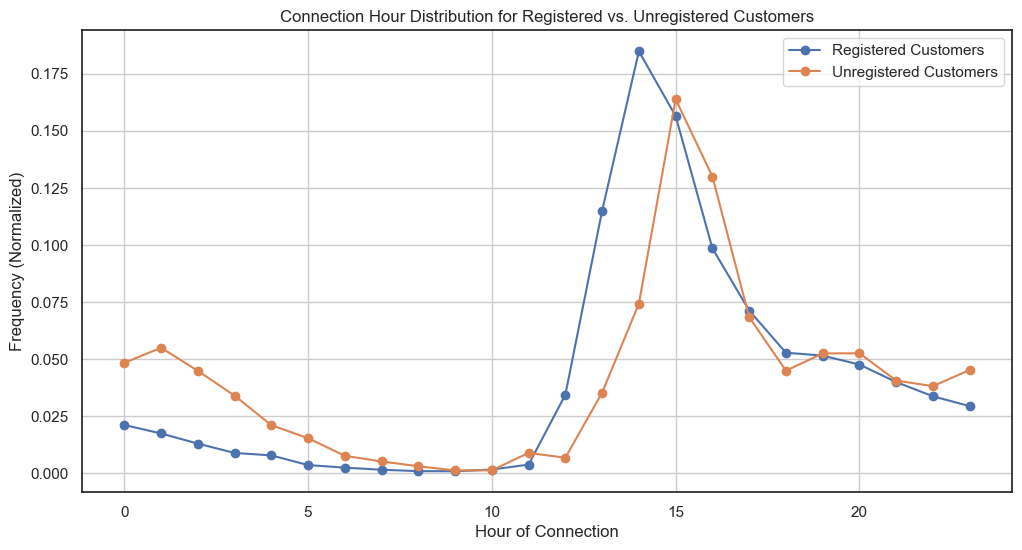

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named charging_sessions_modified

# Separate registered and unregistered customers
registered_customers = data_withNULL[data_withNULL['userID'].notnull()]
unregistered_customers = data_withNULL[data_withNULL['userID'].isnull()]

# Calculate the ratio of registered to unregistered customers
registered_count = len(registered_customers)
unregistered_count = len(unregistered_customers)
registered_to_unregistered_ratio = registered_count / unregistered_count

print("Registered to Unregistered Customers Ratio:", registered_to_unregistered_ratio)

# Analyze when registered users typically connect compared to unregistered users
registered_hourly_distribution = registered_customers['hour_connecttime'].value_counts(normalize=True).sort_index()
unregistered_hourly_distribution = unregistered_customers['hour_connecttime'].value_counts(normalize=True).sort_index()

# Plot the connection hours for registered and unregistered customers
plt.figure(figsize=(12, 6))
plt.plot(registered_hourly_distribution.index, registered_hourly_distribution.values, label='Registered Customers', marker='o')
plt.plot(unregistered_hourly_distribution.index, unregistered_hourly_distribution.values, label='Unregistered Customers', marker='o')
plt.xlabel('Hour of Connection')
plt.ylabel('Frequency (Normalized)')
plt.title('Connection Hour Distribution for Registered vs. Unregistered Customers')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
